### Audio files are commented to reduce size of ipynb file

In [12]:
import librosa
import librosa.display
import musdb
import IPython.display as ipd
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
musdb_pth = "./../data/musdb18"
mus = musdb.DB(root=musdb_pth)

track = next(iter(mus))

In [3]:
vocals = track.stems[-1] # -1 in order of stems is vocals
sample = vocals#[:track.rate * 30]
mono = sample.mean(axis=1)

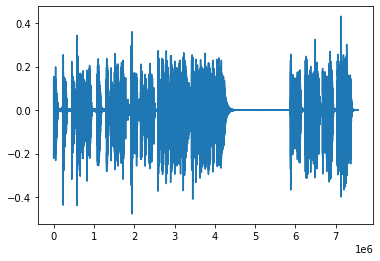

In [4]:
plt.plot(mono)

In [1]:
# ipd.Audio(mono, rate=track.rate)

## Onsets hypothesis

In [52]:
onset_env = librosa.onset.onset_strength(mono, sr=track.rate)

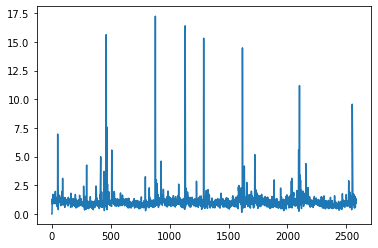

In [53]:
plt.plot(onset_env)

In [54]:
onset_samples = librosa.onset.onset_detect(mono,
                                           sr=track.rate, units='samples', 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

In [55]:
onset_env.shape

(2584,)

In [56]:
onset_samples

array([  25600,  212480,  236544,  260608,  450048,  579584,  659968,
        828416,  882176, 1076224, 1305600])

In [57]:
click_times = onset_samples / track.rate

In [58]:
clicks = librosa.clicks(click_times, sr=track.rate)

In [2]:
# ipd.Audio(clicks, rate=track.rate)

In [60]:
clicks = np.concatenate([clicks, np.zeros(len(mono) - len(clicks))], axis=0)

In [61]:
clicked_mono = mono + clicks

In [3]:
# ipd.Audio(clicked_mono, rate=track.rate)

## HPS approach

In [14]:
split_idxs = np.arange(0, len(mono), len(mono) // 5000)
windows = np.split(mono, split_idxs, axis=0)

In [15]:
import numpy as np
import scipy.fftpack
import os
import matplotlib.pyplot as plt
import copy

# General settings
SAMPLE_FREQ = track.rate # sample frequency in Hz
WINDOW_SIZE = 48000 # window size of the DFT in samples
WINDOW_STEP = 12000 # step size of window
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ # length of the window in seconds
SAMPLE_T_LENGTH = 1 / SAMPLE_FREQ # length between two samples in seconds
NUM_HPS = 8 #max number of harmonic product spectrums
DELTA_FREQ = (SAMPLE_FREQ/WINDOW_SIZE) # frequency step width of the interpolated DFT
windowSamples = [0 for _ in range(WINDOW_SIZE)]
noteBuffer = ["1","2","3"]

# This function finds the closest note for a given pitch
# Returns: note (e.g. a, g#, ..), pitch of the tone
CONCERT_PITCH = 440
ALL_NOTES = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
def find_closest_note(pitch):
    i = int( np.round( np.log2( pitch/CONCERT_PITCH )*12 ) )
    clostestNote = ALL_NOTES[i%12] + str(4 + np.sign(i) * int( (9+abs(i))/12 ) )
    closestPitch = CONCERT_PITCH*2**(i/12)
    return clostestNote, closestPitch

hannWindow = np.hanning(WINDOW_SIZE)
def callback(indata):
    global windowSamples, lastNote
    if any(indata):
        windowSamples = np.concatenate((windowSamples,indata[:, 0])) # append new samples
        windowSamples = windowSamples[len(indata[:, 0]):] # remove old samples

        signalPower = (np.linalg.norm(windowSamples, ord=2)**2) / len(windowSamples)
        if signalPower < 5e-7:
#             os.system('cls' if os.name=='nt' else 'clear')
#             print("Closest note: ...")
            return

        hannSamples = windowSamples * hannWindow
        magnitudeSpec = abs( scipy.fftpack.fft(hannSamples)[:len(hannSamples)//2] )

        #supress mains hum
        for i in range(int(62/DELTA_FREQ)):
            magnitudeSpec[i] = 0

        #Calculate average energy per frequency for the octave bands
        octaveBands = [50,100,200,400,800,1600,3200,6400,12800,25600]
        for j in range(len(octaveBands)-1):
            indStart = int(octaveBands[j]/DELTA_FREQ)
            indEnd = int(octaveBands[j+1]/DELTA_FREQ)
            indEnd = indEnd if len(magnitudeSpec) > indEnd else len(magnitudeSpec)
            avgEnergPerFreq = 1*(np.linalg.norm(magnitudeSpec[indStart:indEnd], ord=2)**2) / (indEnd-indStart)
            avgEnergPerFreq = avgEnergPerFreq**0.5
            for i in range(indStart, indEnd):
                magnitudeSpec[i] = magnitudeSpec[i] if magnitudeSpec[i] > avgEnergPerFreq else 0  #suppress white noise

        #Interpolate spectrum
        magSpecIpol = np.interp(np.arange(0, len(magnitudeSpec), 1/NUM_HPS), np.arange(0, len(magnitudeSpec)), magnitudeSpec)
        magSpecIpol = magSpecIpol / np.linalg.norm(magSpecIpol, ord=2) #normalize it

        hpsSpec = copy.deepcopy(magSpecIpol)

        for i in range(NUM_HPS):
            tmpHpsSpec = np.multiply(hpsSpec[:int(np.ceil(len(magSpecIpol)/(i+1)))], magSpecIpol[::(i+1)])
            if not any(tmpHpsSpec):
                break
            hpsSpec = tmpHpsSpec

        maxInd = np.argmax(hpsSpec)
        maxFreq = maxInd * (SAMPLE_FREQ/WINDOW_SIZE) / NUM_HPS

        maxFreq = round(maxFreq, 1)
        return maxFreq

In [16]:
freqs = []

for window in tqdm(windows, mininterval=1):
    pred_freq = callback(window.reshape(-1, 1))
    freqs.append(pred_freq)

100%|███████████████████████████████████████| 5003/5003 [01:03<00:00, 78.43it/s]


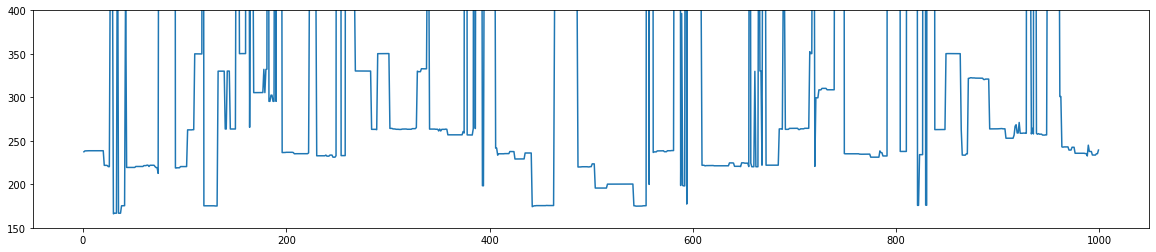

In [21]:
plt.figure(figsize=(20, 4))
plt.ylim((150, 400))
plt.plot(freqs[:1000])

In [22]:
durations = list(split_idxs[1:] - split_idxs[:-1])
durations.append(len(mono) - split_idxs[-1])

In [23]:
def generate_sine(f0, sr, n_duration):
    if f0 is None or np.isnan([f0]).all() or f0 == 0:
        return np.zeros(n_duration)
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))


In [24]:

# notes = [generate_sine(freq, track.rate, 768) for freq in detected_freqs]
notes = np.array([])
for idx, (freq, dur) in enumerate(zip(freqs, durations)):
    if idx % 10 == 0:
        notes = np.concatenate([notes, generate_sine(freq, track.rate, sum(durations[idx: idx + 10]))])

In [4]:
# ipd.Audio(notes, rate=track.rate)

In [26]:
notes_and_voice = notes + mono

In [5]:
# ipd.Audio(notes_and_voice, rate=track.rate)

# CREPE

In [7]:
mix = track.audio # -1 in order of stems is vocals
mix_mono = mix.mean(axis=1)

In [8]:
from scipy.io.wavfile import write

write("mix.wav", track.rate, mix_mono)

In [16]:
!crepe man_sings.wav  --save-plot --plot-voicing --model-capacity tiny

CREPE: Processing man_sings.wav ... (1/1)
2021-08-07 20:46:02.998788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-07 20:46:02.998811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-07 20:46:03.758684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-07 20:46:03.758710: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-07 20:46:03.758723: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gldsn-hw): /proc/driver/nvidia/version does not exist
2021-08-07 20:46:03.758860

In [17]:
pred_df = pd.read_csv("man_sings.f0.csv")
pred_df.head(3)

,time,frequency,confidence
0,0.00,237.809,0.738518
1,0.01,237.434,0.868582
2,0.02,237.841,0.893885


In [18]:
from math import log


def not_nan_mean(freq):
    return freq[freq.notnull()].mean()

    
def not_nan_count(freq):
    return freq.notnull().sum()

    
def anomaly_metric(row):
    return log(1 + 1 / row["not_nan_count"]) * abs(row["frequency"] - row["not_nan_mean"])

In [19]:
pred_df[pred_df["confidence"] < 0.5] = None

roll_freq = pred_df["frequency"].rolling(window=100, min_periods=1)

pred_df["not_nan_count"] = roll_freq.apply(not_nan_count)
pred_df["not_nan_mean"] = roll_freq.apply(not_nan_mean)
pred_df["anomaly_score"] = pred_df.apply(anomaly_metric, axis=1)

In [20]:
pred_df.head(3)

,time,frequency,confidence,not_nan_count,not_nan_mean,anomaly_score
0,0.00,237.809,0.738518,1.0,237.809000,0.000000
1,0.01,237.434,0.868582,2.0,237.621500,0.076025
2,0.02,237.841,0.893885,3.0,237.694667,0.042097


<AxesSubplot:>

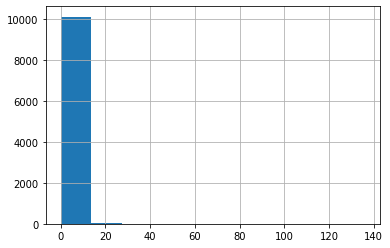

In [21]:
pred_df["anomaly_score"].hist()

In [22]:
pred_df["anomaly_score"].quantile(0.97)

2.3655434451726713

In [23]:
pred_df[pred_df["anomaly_score"] > 2.5] = None

<AxesSubplot:>

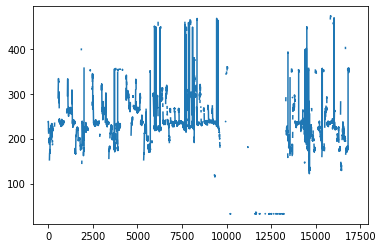

In [24]:
pred_df["frequency"].plot()

<AxesSubplot:>

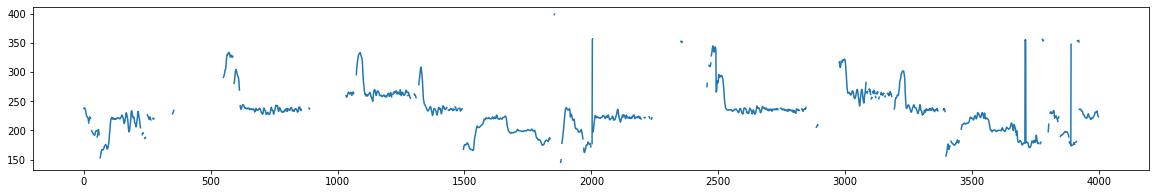

In [25]:
plt.figure(figsize=(20, 3))
pred_df["frequency"].iloc[:4000].plot()

In [26]:
len(mono) / len(pred_df)

440.992700729927

In [29]:
notes_batches = []
take_every = 10

for idx, freq in enumerate(pred_df["frequency"]):
    if idx % take_every == 0:
        sine = generate_sine(freq, track.rate, 441 * take_every)
        if np.nan in sine:
            print(sone.count(np.nan))
        notes_batches.append(sine)

In [30]:
notes = np.concatenate(notes_batches)
notes = notes[:len(mono)]
ipd.Audio(notes, rate=track.rate)

In [6]:
notes_and_voice = notes + mono
# ipd.Audio(notes_and_voice, rate=track.rate)

NameError: name 'notes' is not defined

## pYIN

In [38]:
%%time
pyin_preds = librosa.pyin(mono, sr=track.rate, fmin=200, fmax=3500)

CPU times: user 42.1 s, sys: 800 ms, total: 42.9 s
Wall time: 42.8 s


In [39]:
preds, _, _ = pyin_preds

In [41]:
len(mono) / len(preds)

511.9652904887804

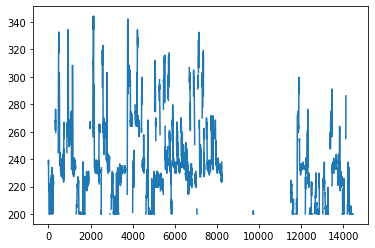

In [45]:
plt.plot(preds)

In [42]:
pyin_notes = []

take_every = 10

for idx, freq in enumerate(preds):
    if idx % take_every == 0:
        sine = generate_sine(freq, track.rate, 512 * take_every)
        if np.nan in sine:
            print(sone.count(np.nan))
        pyin_notes.append(sine)

In [43]:
notes = np.concatenate(pyin_notes)

In [7]:
# ipd.Audio(notes, rate=track.rate)